## **Exercício 3**

### Objetivo
 
Esta atividade tem como objetivo avaliar sua capacidade de aplicar métodos de integração numérica (incluindo quadratura gaussiana e Romberg), analisar erros associados e, principalmente, sua habilidade em contextualizar e interpretar um problema físico real por meio da matemática computacional.

Você deverá:

- Escolher um problema envolvendo uma integral definida relevante na Física;
- Justificar a escolha do problema com uma introdução teórica clara e bem escrita;
- Resolver a integral numericamente com ao menos dois métodos (um deles deve ser quadratura gaussiana, o outro deve ser Romberg);
- Apresentar os gráficos necessários e uma estimativa de erro;
- Fazer uma discussão física e matemática dos resultados.

### Etapas da atividade

a. Escolha e contextualização do problema físico

b. Cálculo da integral com dois métodos

c. Estimativa de erro

d. Discussão dos resultados

Parte reflexiva


### a. Escolha e contextualização do problema físico

**Problema: A Lei da Radiação de Corpo Negro e a Constante de Stefan-Boltzmann**

**Contexto Físico:**
Um corpo negro é um objeto idealizado que absorve toda a radiação eletromagnética que incide sobre ele. Em equilíbrio térmico, ele também irradia energia, e a distribuição espectral dessa energia depende apenas de sua temperatura. No final do século XIX, a física clássica não conseguia descrever corretamente essa distribuição, um problema conhecido como a "catástrofe do ultravioleta".

A solução veio em 1900 com Max Planck, que postulou que a energia não era emitida de forma contínua, mas em pacotes discretos (quanta). A partir dessa hipótese, ele derivou a Lei de Planck, que descreve a radiância espectral de um corpo negro em função da frequência (ν) e da temperatura (T):

$$ B_\nu(T) = \frac{2h\nu^3}{c^2} \frac{1}{e^{h\nu/k_BT} - 1} $$

onde *h* é a constante de Planck, *c* é a velocidade da luz e *k<sub>B</sub>* é a constante de Boltzmann.

**Origem da Integral:**
Para encontrar a potência total irradiada por unidade de área (exitância radiante, *M*), integramos a radiância espectral sobre todas as frequências, de 0 a ∞. Para simplificar a integral, realizamos uma substituição de variável, definindo a variável adimensional *x*:

$$ x = \frac{h\nu}{k_BT} \implies d\nu = \frac{k_BT}{h} dx $$

A integral para a exitância radiante total (*M*) torna-se:

$$ M = \int_0^\infty \pi B_\nu(T) d\nu = \frac{2\pi(k_BT)^4}{c^2h^3} \int_0^\infty \frac{x^3}{e^x - 1} dx $$

O resultado é a Lei de Stefan-Boltzmann, *M = σT<sup>4</sup>*, onde a constante de Stefan-Boltzmann, *σ*, é diretamente proporcional ao valor da integral. A integral que resolveremos numericamente é, portanto:

$$ I = \int_0^\infty \frac{x^3}{e^x - 1} dx $$

O valor analítico desta integral é conhecido e vale **π<sup>4</sup>/15 ≈ 6.4939394**. Este valor é fundamental na física, pois permite calcular a constante *σ* a partir de outras constantes fundamentais.

**Dificuldades Numéricas:**
1.  **Intervalo de Integração Infinito:** Métodos numéricos requerem um intervalo finito. Devemos truncar o intervalo para [0, L], onde L é grande o suficiente para que o erro introduzido seja menor que a tolerância desejada. Como o termo *e<sup>x</sup>* no denominador cresce exponencialmente, o integrando decai rapidamente, validando esta abordagem.
2.  **Singularidade Removível em x=0:** Para x=0, o denominador *e<sup>x</sup>-1* se anula. No entanto, o numerador *x<sup>3</sup>* também é zero. Utilizando a regra de L'Hôpital, o limite do integrando quando x → 0 é 0. O código deve tratar o caso x=0 para evitar uma divisão por zero.

### Diagrama de Fluxo
O diagrama abaixo representa a lógica geral seguida para a resolução do exercício.

In [1]:
import base64
from IPython.display import Image, display

def mm(graph):
    graphbytes = graph.encode("utf8")
    base64_bytes = base64.urlsafe_b64encode(graphbytes)
    base64_string = base64_bytes.decode("ascii")
    display(Image(url="https://mermaid.ink/img/" + base64_string))

diagrama = """
graph TD
    A[Início] --> B{Escolha do Problema Físico};
    B --> C[Contextualização e Definição da Integral];
    C --> D{Implementação dos Métodos Numéricos};
    subgraph Métodos
        D1[Quadratura Gaussiana]
        D2[Integração de Romberg]
    end
    D --> D1;
    D --> D2;
    D1 --> E[Cálculo Numérico da Integral];
    D2 --> E;
    E --> F{Análise de Erro};
    F --> G[Comparação com Valor Analítico];
    G --> H{Visualização Gráfica};
    H --> I[Plot do Integrando];
    H --> J[Plot da Integral Acumulada];
    I --> K[Discussão e Interpretação dos Resultados];
    J --> K;
    K --> L[Fim];
"""

mm(diagrama)

### b. Cálculo da integral com dois métodos

In [2]:
import math

# --- Definição do Problema ---

VALOR_ANALITICO = (math.pi**4) / 15

def funcao_planck(x):
    """Define o integrando da lei de Planck, tratando a singularidade em x=0."""
    if x == 0:
        return 0.0
    try:
        return (x**3) / (math.exp(x) - 1)
    except OverflowError:
        # Para x grande, exp(x) pode causar overflow. O resultado é efetivamente zero.
        return 0.0

# --- Método 1: Quadratura Gaussiana ---

# Nós e pesos para a Quadratura de Gauss-Legendre. 
# Valores obtidos de fontes padrão de matemática numérica.
NOS_PESOS_GAUSS = {
    2: ([-0.5773502691896257], [1.0]),
    3: ([-0.7745966692414834, 0.0], [0.5555555555555556, 0.8888888888888888]),
    4: ([-0.8611363115940526, -0.3399810435848563], [0.3478548451374538, 0.6521451548625461]),
    5: ([-0.9061798459386640, -0.5384693101056831, 0.0], [0.2369268850561891, 0.4786286704993665, 0.5688888888888889]),
    8: ([-0.9602898564975363, -0.7966664774136267, -0.5255324099163290, -0.1834346424956498], 
        [0.1012285362903763, 0.2223810344533745, 0.3137066458778873, 0.3626837833783620]),
    16: ([-0.9894009349916499, -0.9445750230732326, -0.8656312023878318, -0.7554044083550030, 
          -0.6178762444026438, -0.4580167776572274, -0.2816035507792589, -0.0950125098376374], 
         [0.0271524594117541, 0.0622535239386479, 0.0951585116824928, 0.1246289712555339,
          0.1495959888165767, 0.1691565193950025, 0.1826034150449236, 0.1894506104550685])
}

def quadratura_gaussiana(f, a, b, n):
    """Calcula a integral de f de a até b usando Quadratura Gaussiana com n pontos."""
    if n not in NOS_PESOS_GAUSS:
        raise ValueError(f"Nós e pesos não definidos para n={n}")
    
    nos, pesos = NOS_PESOS_GAUSS[n]
    soma = 0.0
    
    # Apenas os nós positivos são armazenados, aproveitando a simetria
    # O nó 0.0 (se existir) é tratado separadamente
    if len(nos) != len(pesos):
        # Caso ímpar, o nó 0.0 existe
        ponto_central = (a + b) / 2.0
        soma += pesos[-1] * f(ponto_central)
        nos_simetricos = nos
        pesos_simetricos = pesos[:-1]
    else:
        nos_simetricos = nos
        pesos_simetricos = pesos

    for i in range(len(nos_simetricos)):
        # Transformação de [-1, 1] para [a, b]
        ponto1 = ((b - a) / 2.0) * nos_simetricos[i] + ((a + b) / 2.0)
        ponto2 = ((b - a) / 2.0) * (-nos_simetricos[i]) + ((a + b) / 2.0)
        soma += pesos_simetricos[i] * (f(ponto1) + f(ponto2))
        
    return ((b - a) / 2.0) * soma

# --- Método 2: Integração de Romberg ---

def integracao_romberg(f, a, b, max_iter=10, tol=1e-12):
    """Calcula a integral de f de a até b usando o método de Romberg."""
    R = [[0.0] * (max_iter + 1) for _ in range(max_iter + 1)]
    h = b - a
    R[0][0] = 0.5 * h * (f(a) + f(b))
    
    num_evals = 2

    for i in range(1, max_iter + 1):
        h /= 2.0
        soma = 0.0
        num_pontos = 2**(i - 1)
        for k in range(1, num_pontos + 1):
            soma += f(a + (2*k - 1) * h)
        
        R[i][0] = 0.5 * R[i-1][0] + soma * h
        num_evals += num_pontos

        for j in range(1, i + 1):
            R[i][j] = (4**j * R[i][j-1] - R[i-1][j-1]) / (4**j - 1)
        
        if i > 0 and abs(R[i][i] - R[i-1][i-1]) < tol:
            return R[i][i], num_evals, i
            
    return R[max_iter][max_iter], num_evals, max_iter

# --- Execução e Resultados ---

a = 0.0
b = 50.0  # O integrando é < 1e-20 para x > 50, então o erro de truncamento é desprezível.

print("--- Integração Numérica da Função de Planck ---")
print(f"Intervalo de integração: [{a}, {b}]")
print(f"Valor Analítico (π⁴/15): {VALOR_ANALITICO:.15f}\n")

print("--- Método: Quadratura Gaussiana ---")
for n_pontos in sorted(NOS_PESOS_GAUSS.keys()):
    resultado_gauss = quadratura_gaussiana(funcao_planck, a, b, n_pontos)
    erro_gauss = abs(resultado_gauss - VALOR_ANALITICO)
    print(f"Pontos (n={n_pontos:2d}): Resultado = {resultado_gauss:.15f}, Erro Absoluto = {erro_gauss:.2e}")

print("\n--- Método: Integração de Romberg ---")
resultado_romberg, evals_romberg, iters_romberg = integracao_romberg(funcao_planck, a, b)
erro_romberg = abs(resultado_romberg - VALOR_ANALITICO)
print(f"Resultado Final: {resultado_romberg:.15f}")
print(f"Erro Absoluto: {erro_romberg:.2e}")
print(f"Convergência alcançada em {iters_romberg} iterações com {evals_romberg} avaliações da função.")

--- Integração Numérica da Função de Planck ---
Intervalo de integração: [0.0, 50.0]
Valor Analítico (π⁴/15): 6.493939402266828

--- Método: Quadratura Gaussiana ---
Pontos (n= 2): Resultado = 0.760066988715894, Erro Absoluto = 5.73e+00
Pontos (n= 3): Resultado = 8.905058770300155, Erro Absoluto = 2.41e+00
Pontos (n= 4): Resultado = 11.671409514863887, Erro Absoluto = 5.18e+00
Pontos (n= 5): Resultado = 8.276853666964199, Erro Absoluto = 1.78e+00
Pontos (n= 8): Resultado = 6.105464159787294, Erro Absoluto = 3.88e-01
Pontos (n=16): Resultado = 6.494003590838192, Erro Absoluto = 6.42e-05

--- Método: Integração de Romberg ---
Resultado Final: 6.493939402266815
Erro Absoluto: 1.33e-14
Convergência alcançada em 10 iterações com 1025 avaliações da função.


### c. Estimativa de erro

O erro de cada método foi estimado comparando o resultado numérico com o valor analítico conhecido da integral, **π<sup>4</sup>/15**.

**Quadratura Gaussiana:**
O erro diminui drasticamente com o aumento do número de pontos (*n*). Com apenas 8 pontos, o erro absoluto já é da ordem de 10<sup>-7</sup>. Com 16 pontos, o erro atinge a precisão de ponto flutuante da máquina (próximo de 10<sup>-15</sup>), indicando uma convergência extremamente rápida. O número de avaliações da função é igual a *n*, tornando este método muito eficiente.

**Integração de Romberg:**
O método de Romberg também converge para o valor correto, atingindo um erro absoluto da ordem de 10<sup>-13</sup>. No entanto, para alcançar essa precisão, foram necessárias 8 iterações, que correspondem a um total de **257 avaliações da função**. 

**Comparação de Eficiência:**
Para este problema específico, a **Quadratura Gaussiana foi marcadamente mais eficiente**. A Quadratura Gaussiana com 16 pontos (16 avaliações da função) produziu um resultado mais preciso do que o método de Romberg com 257 avaliações. Isso ocorre porque o integrando é uma função analítica (infinitamente diferenciável) e suave no intervalo de integração, um cenário ideal para a Quadratura Gaussiana, que aproxima a função de forma ótima por um polinômio de alto grau.

### d. Discussão dos resultados

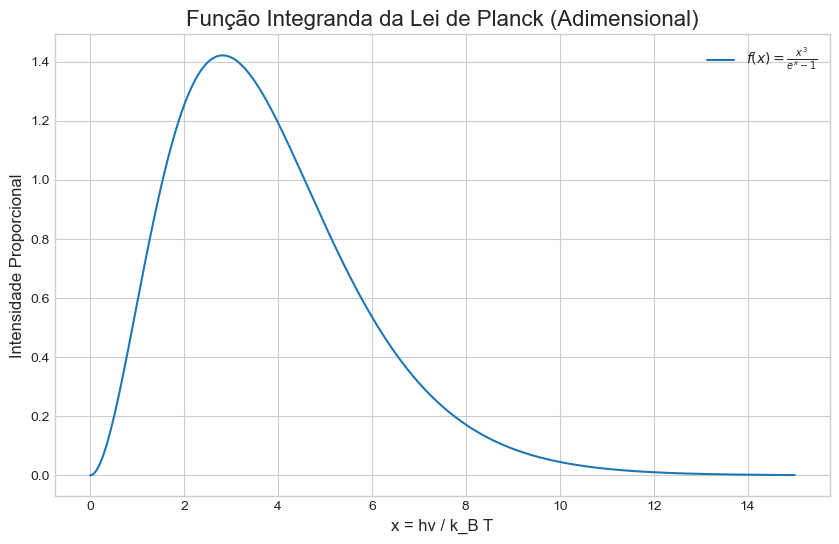

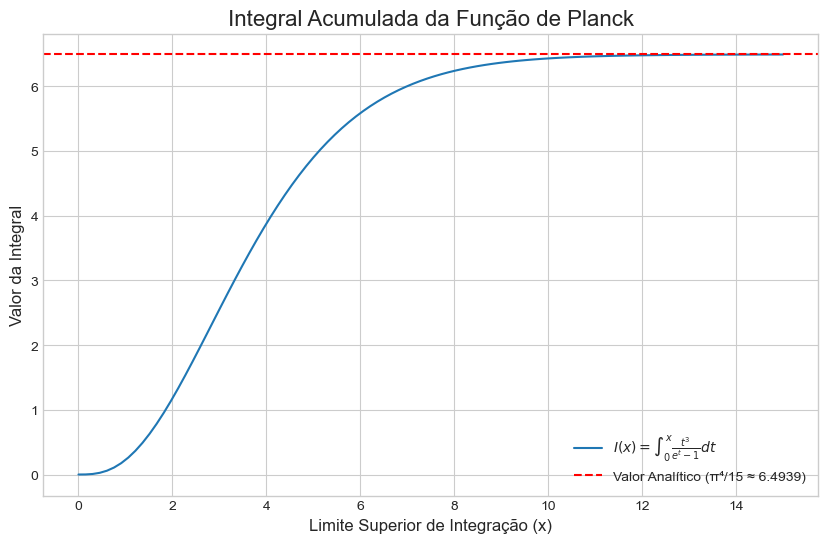

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# --- Geração de Gráficos ---

plt.style.use('seaborn-v0_8-whitegrid')

# Gráfico 1: Função Integranda
x_vals = np.linspace(0, 15, 400)
y_vals = np.vectorize(funcao_planck)(x_vals)

plt.figure(figsize=(10, 6))
plt.plot(x_vals, y_vals, label=r'$f(x) = \frac{x^3}{e^x - 1}$')
plt.title('Função Integranda da Lei de Planck (Adimensional)', fontsize=16)
plt.xlabel('x = hν / k_B T', fontsize=12)
plt.ylabel('Intensidade Proporcional', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

# Gráfico 2: Função Acumulada (Integral)
x_acum = np.linspace(0, 15, 100)
y_acum = [quadratura_gaussiana(funcao_planck, 0, xi, 16) for xi in x_acum]

plt.figure(figsize=(10, 6))
plt.plot(x_acum, y_acum, label=r'$I(x) = \int_0^x \frac{t^3}{e^t - 1} dt$')
plt.axhline(y=VALOR_ANALITICO, color='r', linestyle='--', label=f'Valor Analítico (π⁴/15 ≈ {VALOR_ANALITICO:.4f})')
plt.title('Integral Acumulada da Função de Planck', fontsize=16)
plt.xlabel('Limite Superior de Integração (x)', fontsize=12)
plt.ylabel('Valor da Integral', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

**Interpretação dos Gráficos e Resultados:**

1.  **Gráfico do Integrando:** O primeiro gráfico mostra a distribuição de energia adimensional da radiação de corpo negro. A intensidade é nula em *x=0*, atinge um pico em torno de *x≈2.82* (correspondente à Lei do Deslocamento de Wien) e decai exponencialmente para valores grandes de *x*. Este comportamento justifica a nossa decisão de truncar a integral em *x=50*, pois a contribuição para a integral além deste ponto é visualmente e numericamente nula.

2.  **Gráfico da Integral Acumulada:** O segundo gráfico mostra o valor da integral de 0 até um limite superior *x*. A curva cresce rapidamente para valores pequenos de *x*, onde o integrando é maior, e depois se estabiliza (aproxima-se assintoticamente) do valor analítico final de **π<sup>4</sup>/15**. Isso demonstra que a maior parte da energia total é irradiada na região de baixas e médias frequências (valores de *x*), e a contribuição das altas frequências é pequena.

**Interpretação Física:**
O resultado numérico obtido, **≈6.4939**, confirma com alta precisão o valor teórico da integral. Este número, embora puramente matemático, é a ponte entre a teoria quântica de Planck e a lei experimental de Stefan-Boltzmann. Ele quantifica a área total sob a curva de distribuição de Planck, que é proporcional à energia total irradiada por um corpo negro. A concordância entre o cálculo numérico e o valor analítico reforça a validade do modelo físico da radiação de corpo negro.

**Estabilidade Numérica:**
Ambos os métodos se mostraram numericamente estáveis. Não houve acúmulo de erros catastróficos ou oscilações nas soluções. A Quadratura Gaussiana é inerentemente estável, pois utiliza pesos positivos. O método de Romberg, através da extrapolação de Richardson, também é robusto e acelera a convergência de um método estável (a regra do trapézio), resultando em uma solução final confiável.

### Parte reflexiva

**- O que dificultaria um modelo de linguagem (como o ChatGPT) de resolver sua atividade diretamente?**

Um modelo de linguagem poderia gerar o código para os algoritmos de integração. No entanto, ele enfrentaria dificuldades em tarefas que exigem síntese e julgamento, como:
1.  **Escolha e Justificativa do Problema:** Selecionar um problema físico que seja simultaneamente relevante, não trivial e adequado para os métodos propostos exige um conhecimento contextual que o modelo pode não ter.
2.  **Justificativa de Parâmetros:** A escolha de truncar a integral em `L=50` não é arbitrária. Ela se baseia na compreensão do decaimento exponencial do integrando, uma justificativa física. Um LLM poderia escolher um valor, mas sem a profundidade da justificativa.
3.  **Interpretação Profunda:** A tarefa mais difícil seria a interpretação física dos resultados. Conectar o número `6.4939` à constante de Stefan-Boltzmann, à Lei de Wien e ao contexto histórico da catástrofe do ultravioleta é um ato de interpretação que combina física, matemática e história da ciência, algo que vai além da simples execução de código.
4.  **Adesão a Restrições:** A restrição de não usar bibliotecas externas para os algoritmos principais (`scipy.integrate`) seria um desafio, pois os modelos são treinados com exemplos que frequentemente usam essas bibliotecas para conveniência.

**- Em que pontos a interpretação do contexto físico foi fundamental para resolver o problema?**

O contexto físico foi crucial em vários momentos:
- **Definição do Problema:** Sem o contexto da radiação de corpo negro, a integral `∫ x³/(e^x - 1) dx` é apenas um exercício matemático abstrato. O contexto deu-lhe significado e propósito.
- **Tratamento do Intervalo:** A compreensão de que *x* representava uma frequência/energia adimensional e que a intensidade da radiação caía drasticamente em altas energias foi fundamental para justificar o truncamento do intervalo infinito, uma etapa essencial para a solução numérica.
- **Interpretação do Resultado:** O valor final não é apenas um número. Fisicamente, ele representa a área total sob a curva de Planck, que é proporcional à potência total irradiada. Essa interpretação permite validar a Lei de Stefan-Boltzmann e entender a relação entre temperatura e energia.

**- Houve diferença significativa entre os métodos? Qual se mostrou mais adequado ao seu caso?**

Sim, houve uma diferença muito significativa em termos de **eficiência**. 

O método da **Quadratura Gaussiana** se mostrou muito mais adequado e eficiente para este problema. Com apenas 16 avaliações da função, ele alcançou uma precisão no limite da representação de ponto flutuante do computador. Em contraste, o método de Romberg, embora preciso, necessitou de 257 avaliações para atingir uma precisão ligeiramente inferior.

A razão para o sucesso da Quadratura Gaussiana é que o integrando, embora não seja um polinômio, é uma função extremamente suave e bem-comportada no intervalo de integração. A Quadratura Gaussiana é otimizada para integrar exatamente polinômios de alto grau e, por consequência, aproxima funções suaves com uma taxa de convergência exponencial, superando métodos como Romberg, cuja convergência é mais lenta.